In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb

import shap
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import clone

from processing_functions import *

In [2]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('data/input_file.csv')
#nan_percentage(df) 

## Processing

There is a lot of data missing for how people think others perceive them, and what attributes they think the rest of their sex prefer. 

Since I am also going to be working with no gender, I will drop any column related to the binary separation of gender.

The attribute that overall has the most amount of missing data is 'shared interests'. I was hoping to use this attribute as a reliable feature to find partners, but based on the findings made in the EDA it is the feature that is the least important. 

In [3]:
def drop_columns(df, suffix):
    cols = [col for col in df.columns if any(col.endswith(s) for s in suffix)]
    
    df = df.drop(columns=cols, errors='ignore')
    
    return df
    

suffix= ['_fellow_want', 'perceived', '_o_want', '_diff']
df = drop_columns(df, suffix)
df_final = df.drop(columns=['Unnamed: 0'])
df_pred = df_final.copy(deep=True)

Since there are too many people and waves in this experiment, I am going to opt to drop the rows that have nan values so that it is easier to work with when it comes to training the dataset (especially with Random Forest). 

In [4]:
df_final.head()

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.0,20.0,...,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.0,0.0,...,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
2,1,1.0,1,3,13.0,1,0.16,22.0,19.0,18.0,...,7.0,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN
3,1,1.0,1,4,14.0,1,0.61,23.0,30.0,5.0,...,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.0,10.0,...,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0


In [5]:
df_nan = df_final.dropna()
df_nan['wave'].unique()
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1252 entries, 0 to 1843
Data columns (total 67 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   iid              1252 non-null   int64  
 1   id               1252 non-null   float64
 2   wave             1252 non-null   int64  
 3   partner          1252 non-null   int64  
 4   pid              1252 non-null   float64
 5   match            1252 non-null   int64  
 6   int_corr         1252 non-null   float64
 7   age_o            1252 non-null   float64
 8   pf_o_att         1252 non-null   float64
 9   pf_o_sin         1252 non-null   float64
 10  pf_o_int         1252 non-null   float64
 11  pf_o_fun         1252 non-null   float64
 12  pf_o_amb         1252 non-null   float64
 13  pf_o_sha         1252 non-null   float64
 14  dec_o            1252 non-null   int64  
 15  attr_o           1252 non-null   float64
 16  sinc_o           1252 non-null   float64
 17  intel_o       

In [6]:
waves = [1, 2, 3, 4, 5]

df_1 = df_final[df_final['wave'] == 1]
df_rest = df_nan[df_nan['wave'].isin([2, 3, 4, 5])]
print(df_1.isnull().sum().to_list())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 10, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 10, 0, 3]


In [7]:
df_1[['iid', 'pid', 'match', 'prob', 'prob_o', 'shar', 'amb', 'attr', 'attr_o', 'amb_o', 'shar_o']].iloc[0:30]

,iid,pid,match,prob,prob_o,shar,amb,attr,attr_o,amb_o,shar_o
0,1,11.0,0,6.0,4.0,5.0,6.0,6.0,6.0,8.0,6.0
1,1,12.0,0,5.0,4.0,6.0,5.0,7.0,7.0,7.0,5.0
2,1,13.0,1,NaN,10.0,7.0,5.0,5.0,10.0,10.0,10.0
3,1,14.0,1,6.0,7.0,8.0,6.0,7.0,7.0,9.0,8.0
4,1,15.0,1,6.0,6.0,6.0,6.0,5.0,8.0,9.0,7.0
5,1,16.0,0,5.0,6.0,4.0,6.0,4.0,7.0,7.0,7.0
6,1,17.0,0,5.0,1.0,7.0,6.0,7.0,3.0,8.0,7.0
7,1,18.0,0,7.0,5.0,6.0,5.0,4.0,6.0,8.0,6.0
8,1,19.0,1,7.0,8.0,8.0,8.0,7.0,7.0,8.0,9.0
9,1,20.0,0,6.0,6.0,8.0,10.0,5.0,6.0,6.0,6.0


In [8]:
# prob, prob_o
def fill_nan(df, col1, col2):
    """
    Fills NaN values in two columns of a DataFrame based on each other's non-NaN values.

    Parameters:
    df (pd.DataFrame): DataFrame containing the columns to be processed.
    col1 (str): Name of the first column.
    col2 (str): Name of the second column.

    Returns:
    pd.DataFrame: DataFrame with NaN values filled in the specified columns.
    """
    df_filled = df.copy()
    df_filled[col1] = df_filled[col1].fillna(df_filled[col2])
    df_filled[col2] = df_filled[col2].fillna(df_filled[col1])

    return df_filled

df_1 = fill_nan(df_1, 'prob', 'prob_o')
df_1 = df_1.fillna(1)
# 0: shar, amb, attr, attr_o, amb_o, shar_o, 

In [9]:
#df_final = df_final.dropna()
print(df_1.isnull().sum().unique())

[0]


In [10]:
columns = df_1.columns.to_list()
df_final = pd.concat([df_1, df_rest], axis=0, ignore_index=True)
df_final.isnull().sum().unique() 

array([0])

In [11]:
# Dropping identifier columns and irrelevant features for prediction
df = df_final.drop(columns=['iid', 'id', 'pid', 'partner', 'wave'], axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Data columns (total 62 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match            1276 non-null   int64  
 1   int_corr         1276 non-null   float64
 2   age_o            1276 non-null   float64
 3   pf_o_att         1276 non-null   float64
 4   pf_o_sin         1276 non-null   float64
 5   pf_o_int         1276 non-null   float64
 6   pf_o_fun         1276 non-null   float64
 7   pf_o_amb         1276 non-null   float64
 8   pf_o_sha         1276 non-null   float64
 9   dec_o            1276 non-null   int64  
 10  attr_o           1276 non-null   float64
 11  sinc_o           1276 non-null   float64
 12  intel_o          1276 non-null   float64
 13  fun_o            1276 non-null   float64
 14  amb_o            1276 non-null   float64
 15  shar_o           1276 non-null   float64
 16  like_o           1276 non-null   float64
 17  prob_o        

## Models training

In [13]:
X = df.drop(['match', 'dec', 'dec_o'], axis=1)
y = df['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [14]:
# Start by modelling a LightGBM and Random Forest model 
# Will do comparison of both and decide based on 
# maybe can try to use LightGBM but using 'random forest' as the boosting_type(?)

lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)

lgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [15]:
rf_accuracy = cross_val_score(rf_model, X_train, y_train, cv=5)
lgb_accuracy = cross_val_score(lgb_model, X_train, y_train, cv=5)
xgb_accuracy = cross_val_score(xgb_model, X_train, y_train, cv=5)

print("Random Forest Accuracy: ", rf_accuracy.mean())
print("LightGBM Accuracy: ", lgb_accuracy.mean())
print("XGBClassifier Accuracy: ", xgb_accuracy.mean())

Random Forest Accuracy:  0.8483660130718954
LightGBM Accuracy:  0.8535947712418303
XGBClassifier Accuracy:  0.8601307189542485


In [16]:
# Comparison between models with classification_report
# Make prediction on the testing data
y_pred_rf = rf_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Classification Report
print("RandomForestClassifier:\n", classification_report(y_test, y_pred_rf, zero_division=0))
print("LightGBM:\n", classification_report(y_pred_lgb, y_test))
print("XGBClassifer:\n", classification_report(y_pred_xgb, y_test))

print("\n")

# F1 Score
print("RandomForestClassifier F1 score:\n", f1_score(y_test, y_pred_rf, zero_division=0, average="weighted"),"\n")
print("LightGBM F1 score:\n", f1_score(y_pred_lgb, y_test, average="weighted"),"\n")
print("XGBClassifer F1 score:\n", f1_score(y_pred_xgb, y_test, average="weighted"))

RandomForestClassifier:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91       201
           1       0.90      0.35      0.50        55

    accuracy                           0.85       256
   macro avg       0.88      0.67      0.71       256
weighted avg       0.86      0.85      0.82       256

LightGBM:
               precision    recall  f1-score   support

           0       0.95      0.87      0.90       219
           1       0.47      0.70      0.57        37

    accuracy                           0.84       256
   macro avg       0.71      0.79      0.73       256
weighted avg       0.88      0.84      0.86       256

XGBClassifer:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91       217
           1       0.51      0.72      0.60        39

    accuracy                           0.85       256
   macro avg       0.73      0.80      0.75       256
weighted avg       0.88

### Threshold computation

In [17]:
df['match'].value_counts(normalize=True)

0    0.799373
1    0.200627
Name: match, dtype: float64

After looking at the accuracy and the other metrics we can see that, same as had previously measured in the EDA, this is a very unbalanced dataset. Almost 80% of the values belong to 0, while only 20% is part of the positive results.

There is a much higher number of 0s (no matches) than 1s (matches), there this makes the precision, accuracy and recall of the matches much more lower than the no matches.

We need to find a weight balance in order to work with it and in return choose the most appropriate model to work with.
References found in: [https://stackoverflow.com/questions/51190809/high-auc-but-bad-predictions-with-imbalanced-data]

We might also want to look into the performance of a =XGBoost= model since it performs better for unbalanced data. 
The boosting algorithm iteratively learns from the mistakes of the previous tree. So if a tree fails to predict a class (most likely the imbalanced class), the proceeding tree will give more weightage to this sample.

In [18]:
def pr_threshold(model, model_name='Model'):
    """
    Calculate and plot the precision-recall curve for a given model and test data.
    Also, find the threshold that yields the highest F1 score using an iterative method and plot the classification report based on this threshold.

    Returns:
    optimal_threshold: The threshold value that yields the highest F1 score.
    optimal_report: Classification report using the optimal threshold.
    """
    # probabilities for the positive class
    probabilities = model.predict_proba(X_val)[:,1]

    # precision, recall, and thresholds using the predicted probabilities
    precision, recall, thresholds = precision_recall_curve(y_val, probabilities)

    # F1 score for each threshold with tiny constant to avoid division by zero
    fscore = (2 * precision * recall) / (precision + recall + 1e-12)

    # Find the index of the maximum F1 score
    optimal_index = np.argmax(fscore)
    best_threshold = thresholds[optimal_index]

    # Make final predictions using the optimal threshold
    final_predictions = (model.predict_proba(X_test)[:,1] >= best_threshold).astype(int)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
    plt.plot(thresholds, (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12), 'r-.', label='F1 Score')
    plt.axvline(x=best_threshold, color='k', linestyle='--', label='Optimal Threshold')
    plt.xlabel('Threshold')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.title(f'{model_name}: Precision, Recall, and F1 Score for different thresholds')
    plt.show()

    optimal_report = classification_report(y_test, final_predictions, zero_division=0)
    return best_threshold, optimal_report

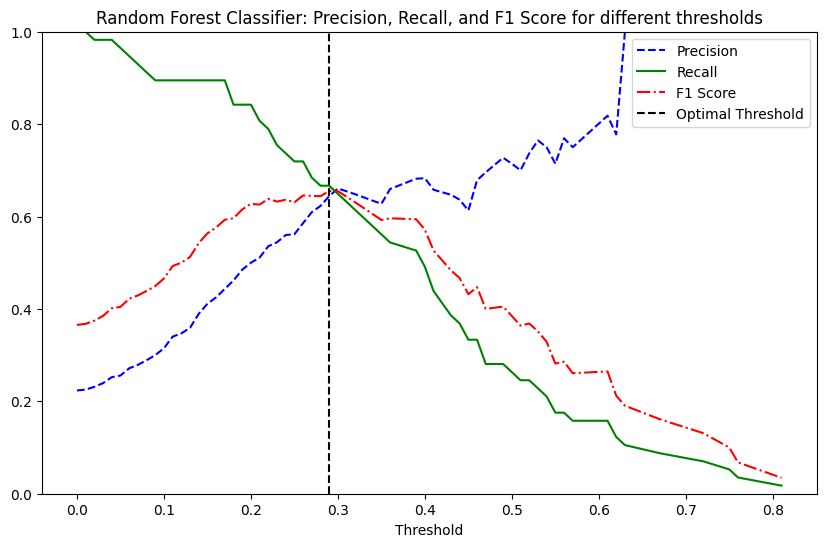

Optimal threshold for maximum Random Forest F1-score: 0.29
Using threshold ~0.2900 for evaluation.

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       201
           1       0.67      0.69      0.68        55

    accuracy                           0.86       256
   macro avg       0.79      0.80      0.79       256
weighted avg       0.86      0.86      0.86       256
 

Random Forest: f1 score 0.8789779243119267


In [19]:
optimal_threshold_rf, optimal_report_rf = pr_threshold(rf_model, model_name='Random Forest Classifier')

print("Optimal threshold for maximum Random Forest F1-score:", optimal_threshold_rf)
print(f"Using threshold ~{optimal_threshold_rf:.4f} for evaluation.\n")
print(optimal_report_rf, "\n")

final_predictions_rf = (rf_model.predict(X_test) >= 0.3).astype(int)
print("Random Forest: f1 score", f1_score(final_predictions_rf, y_test, average="weighted"))

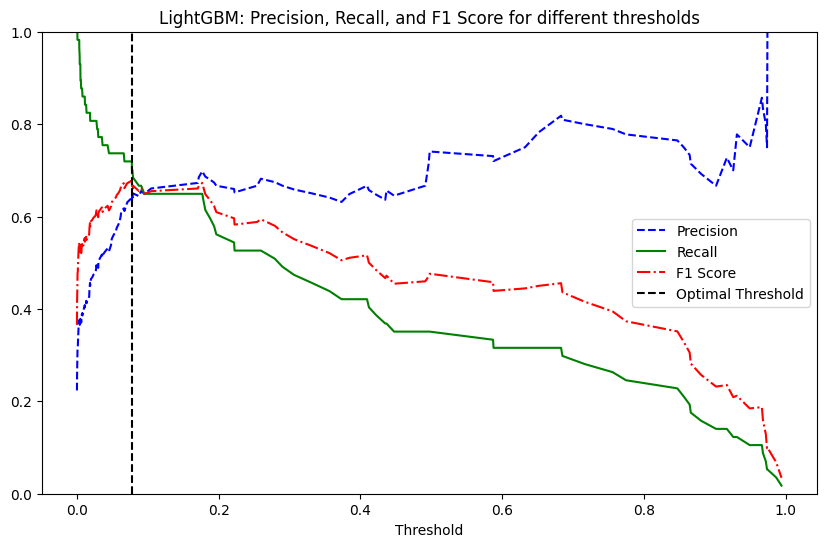

Optimal threshold for maximum LightGBM F1-score: 0.07745959884650663
Using threshold ~0.0775 for evaluation.

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       201
           1       0.60      0.76      0.67        55

    accuracy                           0.84       256
   macro avg       0.77      0.81      0.78       256
weighted avg       0.86      0.84      0.85       256

LightGBM: F1 score 0.8556871118012421


In [20]:
optimal_threshold_lgb, optimal_report_lgb = pr_threshold(lgb_model, model_name='LightGBM')

print("Optimal threshold for maximum LightGBM F1-score:", optimal_threshold_lgb)
print(f"Using threshold ~{optimal_threshold_lgb:.4f} for evaluation.\n")
print(optimal_report_lgb)

final_predictions_lgb = (lgb_model.predict(X_test) >= optimal_threshold_lgb).astype(int)
print("LightGBM: F1 score", f1_score(final_predictions_lgb, y_test, average="weighted"))

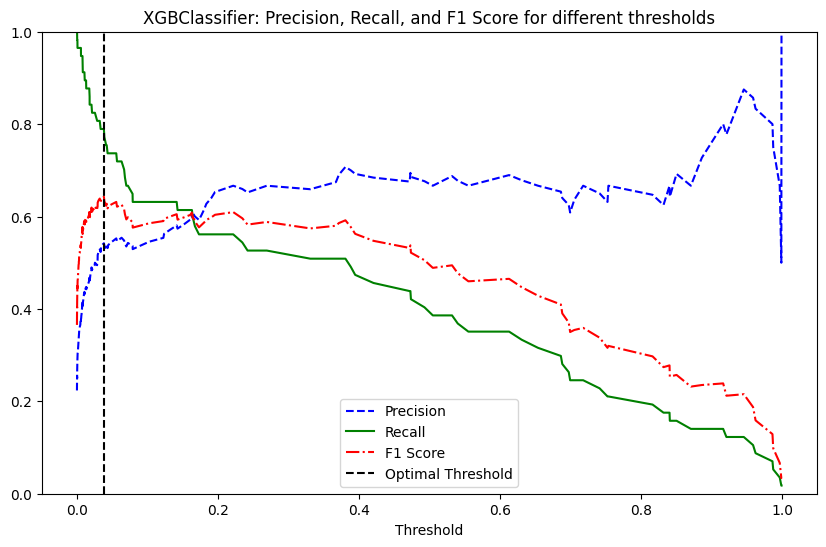

Optimal threshold for maximum XGBClassifier F1-score: 0.03823495
Using threshold ~0.0382 for evaluation.

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       201
           1       0.55      0.85      0.67        55

    accuracy                           0.82       256
   macro avg       0.75      0.83      0.77       256
weighted avg       0.87      0.82      0.83       256

XGBClassifier: F1 score 0.8613545696324951


In [21]:
optimal_threshold_xgb, optimal_report_xgb = pr_threshold(xgb_model, model_name='XGBClassifier')

print("Optimal threshold for maximum XGBClassifier F1-score:", optimal_threshold_xgb)
print(f"Using threshold ~{optimal_threshold_xgb:.4f} for evaluation.\n")
print(optimal_report_xgb)

final_predictions_xgb = (xgb_model.predict(X_test) >= optimal_threshold_xgb).astype(int)
print("XGBClassifier: F1 score", f1_score(final_predictions_xgb, y_test, average="weighted"))

#### GridSearch for XGBoost Classifier

Since XGBoost seems to be the one that behaves the best, we will choose this model to continue the rest of our calculations.

This will be done later on after we have found the SHAP values that influence the most, in order to obtain the match predictions based on them.

### SHAP Values Computation

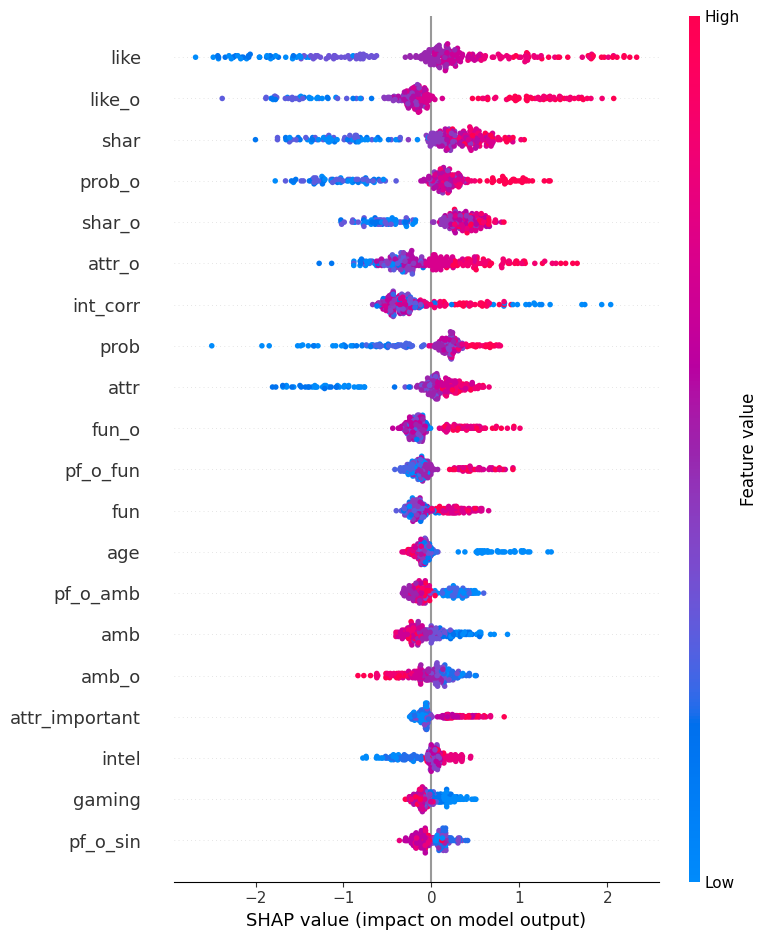

In [22]:
explainer = shap.Explainer(lgb_model, X_train)
shap_values_lgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_lgb, X_test)

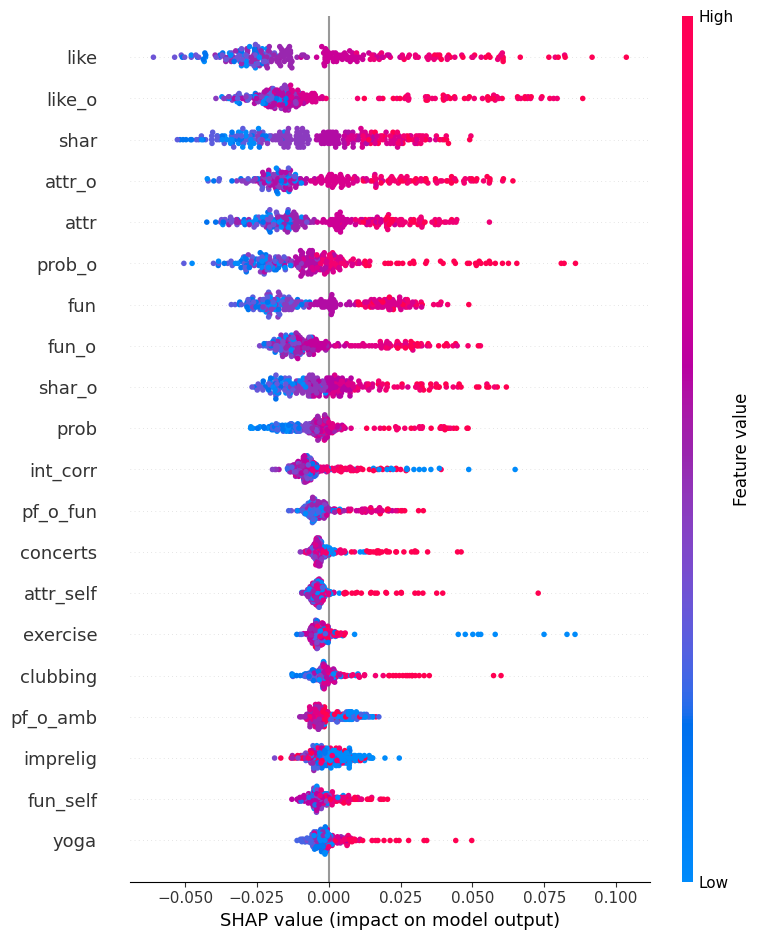

In [23]:
explainer = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer.shap_values(X_test, check_additivity=False)

# Visualize the SHAP values
shap.summary_plot(shap_values_rf[1], X_test)

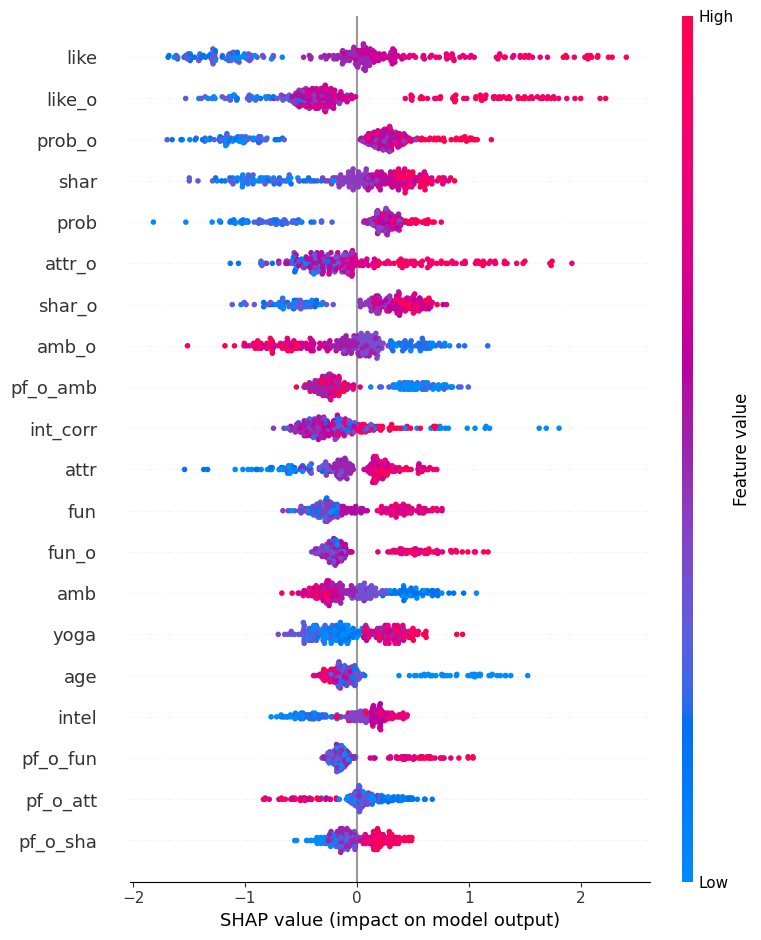

In [24]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values_xgb, X_test)

In [25]:
def shap_importance(model, shap_values):
    """
    Return a dataframe containing the features sorted by Shap importance.

    Parameters:
    model : The tree-based model (like RandomForest, XGBoost, etc.).

    Returns:
    pd.DataFrame
        A dataframe containing the features sorted by Shap importance.
    """
    # explainer = shap.Explainer(model, X_train)
    
    # shap_values = explainer.shap_values(X_test, check_additivity=False)
    
    if isinstance(shap_values, list):
        shap_values = np.abs(shap_values[1])
    else:
        shap_values = np.abs(shap_values)
        
    mean_abs_shap_values = shap_values.mean(axis=0)
    
    feature_importance = pd.DataFrame({
        'features': X_test.columns,
        'importance': mean_abs_shap_values
    })
    
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)
    return feature_importance.reset_index(drop=True).head(30)

top_features = shap_importance(xgb_model, shap_values_xgb).drop([4, 8, 28])

In [26]:
top_features

,features,importance
0,like,0.725010
1,like_o,0.666102
2,prob_o,0.573818
3,shar,0.455137
5,attr_o,0.427717
6,shar_o,0.424681
7,amb_o,0.381568
9,int_corr,0.324564
10,attr,0.318120
11,fun,0.317721


In [27]:
shap_columns = top_features['features'].to_list()

## Chosen wave data preparation

In [28]:
print(df_final['iid'].unique())
df_final.to_csv('data/clean_data.csv')

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37
  38  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 115 116 117 119 120 121 122 123 124 125 126 127 128 130 131]


In [29]:
df_final[df_final['wave'] == 1]

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.00,20.00,...,7.0,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.00,0.00,...,7.0,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
2,1,1.0,1,3,13.0,1,0.16,22.0,19.00,18.00,...,7.0,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,10.0
3,1,1.0,1,4,14.0,1,0.61,23.0,30.00,5.00,...,7.0,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.00,10.00,...,7.0,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,20,10.0,1,6,6.0,0,0.43,23.0,10.00,25.00,...,10.0,0,7.0,10.0,10.0,6.0,10.0,7.0,6.0,7.0
196,20,10.0,1,7,7.0,0,-0.16,22.0,15.00,15.00,...,10.0,0,7.0,6.0,8.0,6.0,8.0,7.0,7.0,7.0
197,20,10.0,1,8,8.0,1,-0.21,25.0,9.09,18.18,...,10.0,1,8.0,10.0,9.0,9.0,8.0,8.0,8.0,8.0
198,20,10.0,1,9,9.0,0,-0.23,26.0,20.00,10.00,...,10.0,0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0


#### Matches per wave

In [30]:
def wave_matches_display(df):
    # Dictionary to store data for each wave
    wave_data = {}

    # Group by wave and process each group
    for wave, group in df.groupby('wave'):
        # Collect all participants in the wave
        participants = list(group['iid'].unique())
        
        # Collect matches as lists of pairs
        matches = []
        for index, person in group.iterrows():
            if person['match'] == 1 and person['pid'] in group['iid'].values:
                matches.append([person['iid'], person['pid']])
        
        # Storing results in the dictionary with wave as key
        wave_data[wave] = {
            "participants": participants,
            "matches": matches
        }

    # Convert the dictionary into a DataFrame
    wave_df = pd.DataFrame([
        {'wave': wave, 'participants': data['participants'], 'matches': data['matches']}
        for wave, data in wave_data.items()
    ])

    return wave_df

wave_df = wave_matches_display(df_final)
wave_df_pred = wave_matches_display(df_pred)

In [31]:
wave_df

,wave,participants,matches
0,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]","[[1.0, 13.0], [1.0, 14.0], [1.0, 15.0], [1.0, 19.0], [2.0, 14.0], [2.0, 19.0], [4.0, 14.0], [4.0, 19.0], [5.0, 14.0], [5.0, 19.0], [6.0, 14.0], [6.0, 19.0], [7.0, 14.0], [7.0, 19.0], [8.0, 12.0], [8.0, 13.0], [8.0, 14.0], [8.0, 15.0], [8.0, 16.0], [8.0, 18.0], [8.0, 19.0], [8.0, 20.0], [9.0, 12.0], [9.0, 13.0], [9.0, 14.0], [9.0, 15.0], [9.0, 16.0], [9.0, 17.0], [9.0, 19.0], [10.0, 13.0], [10.0, 19.0], [12.0, 8.0], [12.0, 9.0], [13.0, 1.0], [13.0, 8.0], [13.0, 9.0], [13.0, 10.0], [14.0, 1.0], [14.0, 2.0], [14.0, 4.0], [14.0, 5.0], [14.0, 6.0], [14.0, 7.0], [14.0, 8.0], [14.0, 9.0], [15.0, 1.0], [15.0, 8.0], [15.0, 9.0], [16.0, 8.0], [16.0, 9.0], [17.0, 9.0], [18.0, 8.0], [19.0, 1.0], [19.0, 2.0], [19.0, 4.0], [19.0, 5.0], [19.0, 6.0], [19.0, 7.0], [19.0, 8.0], [19.0, 9.0], [19.0, 10.0], [20.0, 8.0]]"
1,2,"[21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]","[[22.0, 44.0], [22.0, 45.0], [23.0, 43.0], [23.0, 44.0], [23.0, 45.0], [27.0, 46.0], [29.0, 44.0], [29.0, 45.0], [30.0, 55.0], [31.0, 55.0], [34.0, 49.0], [35.0, 45.0], [35.0, 46.0], [35.0, 49.0], [35.0, 53.0], [36.0, 49.0], [36.0, 51.0], [37.0, 44.0], [37.0, 52.0], [38.0, 49.0], [38.0, 55.0], [39.0, 47.0], [43.0, 23.0], [44.0, 22.0], [44.0, 23.0], [44.0, 29.0], [44.0, 37.0], [45.0, 22.0], [45.0, 23.0], [45.0, 29.0], [45.0, 35.0], [46.0, 27.0], [46.0, 35.0], [47.0, 39.0], [49.0, 34.0], [49.0, 35.0], [49.0, 36.0], [49.0, 38.0], [51.0, 36.0], [52.0, 37.0], [53.0, 35.0], [55.0, 30.0], [55.0, 31.0], [55.0, 38.0]]"
2,3,"[56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]","[[56.0, 70.0], [57.0, 71.0], [61.0, 71.0], [61.0, 75.0], [62.0, 67.0], [62.0, 74.0], [63.0, 67.0], [64.0, 75.0], [67.0, 62.0], [67.0, 63.0], [70.0, 56.0], [71.0, 57.0], [71.0, 61.0], [74.0, 62.0], [75.0, 61.0], [75.0, 64.0]]"
3,4,"[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]","[[77.0, 94.0], [77.0, 97.0], [77.0, 99.0], [77.0, 105.0], [77.0, 107.0], [78.0, 107.0], [78.0, 109.0], [79.0, 107.0], [79.0, 108.0], [80.0, 102.0], [80.0, 105.0], [80.0, 109.0], [81.0, 99.0], [81.0, 104.0], [81.0, 108.0], [82.0, 94.0], [82.0, 99.0], [82.0, 105.0], [82.0, 107.0], [82.0, 109.0], [83.0, 99.0], [83.0, 107.0], [84.0, 105.0], [84.0, 108.0], [85.0, 107.0], [86.0, 97.0], [86.0, 100.0], [86.0, 104.0], [86.0, 105.0], [86.0, 107.0], [86.0, 108.0], [86.0, 109.0], [86.0, 110.0], [87.0, 99.0], [87.0, 107.0], [89.0, 99.0], [89.0, 104.0], [90.0, 109.0], [92.0, 97.0], [92.0, 99.0], [92.0, 105.0], [92.0, 107.0], [92.0, 109.0], [93.0, 95.0], [93.0, 100.0], [93.0, 104.0], [94.0, 77.0], [94.0, 82.0], [95.0, 93.0], [97.0, 77.0], [97.0, 86.0], [97.0, 92.0], [99.0, 77.0], [99.0, 81.0], [99.0, 82.0], [99.0, 83.0], [99.0, 87.0], [99.0, 89.0], [99.0, 92.0], [100.0, 86.0], [100.0, 93.0], [102.0, 80.0], [104.0, 81.0], [104.0, 86.0], [104.0, 89.0], [104.0, 93.0], [105.0, 77.0], [105.0, 80.0], [105.0, 82.0], [105.0, 84.0], [105.0, 86.0], [105.0, 92.0], [107.0, 77.0], [107.0, 78.0], [107.0, 79.0], [107.0, 82.0], [107.0, 83.0], [107.0, 85.0], [107.0, 86.0], [107.0, 87.0], [107.0, 92.0], [108.0, 79.0], [108.0, 81.0], [108.0, 84.0], [108.0, 86.0], [109.0, 78.0], [109.0, 80.0], [109.0, 82.0], [109.0, 86.0], [109.0, 90.0], [109.0, 92.0], [110.0, 86.0]]"
4,5,"[112, 113, 115, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131]","[[112.0, 122.0], [112.0, 125.0], [112.0, 126.0], [112.0, 127.0], [112.0, 128.0], [113.0, 125.0], [113.0, 126.0], [113.0, 128.0], [115.0, 125.0], [115.0, 127.0], [115.0, 128.0], [116.0, 122.0], [116.0, 125.0], [116.0, 127.0], [117.0, 125.0], [119.0, 125.0], [119.0, 127.0], [120.0, 122.0], [120.0, 125.0], [120.0, 128.0], [122.0, 112.0], [122.0, 116.0], [122.0, 120.0], [125.0, 112.0], [125.0, 113.0], [125.0, 

#### Preparation of first wave dataframe

In [32]:
def indices_column(df, value):
    filtered_df = df[df['wave'] == value]
    indices = filtered_df.index.tolist()
    return indices

# select rows from another dataframe using the obtained indices
def select_rows(df, indices):
    return df.iloc[indices]

indices = indices_column(df_final, 1)
df_wave = select_rows(df_final, indices)
df_wave = df_wave.drop(columns=['id', 'partner', 'wave', 'age_o', 'expnum'], axis=1)
# df_wave = df_wave.drop(df_wave[df_wave['iid'] == 21].index)
# df_wave = df_wave.drop(df_wave[df_wave['iid'] == 22].index)
#print(indices)

In [33]:
df_wave['like']

0      7.0
1      7.0
2      7.0
3      7.0
4      6.0
      ... 
195    6.0
196    7.0
197    8.0
198    6.0
199    7.0
Name: like, Length: 200, dtype: float64

#### Grid Search

Now that we have the desired dataframe we can do now the hyperparameter tuning to obtain the match predictions and include them in the preference lists

In [34]:
X_class = df_wave[shap_columns]
y_class = df_wave['match']

# Define a K-Fold cross-validator
kf = KFold(n_splits=3, shuffle=True, random_state=42) 

param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'random_state': [42]
}

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

grid_search_xgb_classifier = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=kf, verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search_xgb_classifier.fit(X_class, y_class)

print("Best parameters found xgb_classifier:\n", grid_search_xgb_classifier.best_params_)
print("\n The best score across ALL searched params for xgb_classifier:",grid_search_xgb_classifier.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found xgb_classifier:
 {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'random_state': 42, 'subsample': 0.8}

 The best score across ALL searched params for xgb_classifier: 0.8000904568068749


In [35]:
xgb_classifier = grid_search_xgb_classifier.best_estimator_

# Perform cross-validation
cv_results = cross_val_score(xgb_classifier, X_class, y_class, cv=kf, scoring='roc_auc')

# Predict labels and probabilities
y_pred_xgbc = cross_val_predict(xgb_classifier, X_class, y_class, cv=kf)
y_proba_xgbc = cross_val_predict(xgb_classifier, X_class, y_class, cv=kf, method='predict_proba')[:, 1]

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_class, y_pred_xgbc))
print("f1 score:", f1_score(y_pred_xgbc, y_class, average="weighted"))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       138
           1       0.70      0.61      0.66        62

    accuracy                           0.80       200
   macro avg       0.77      0.75      0.76       200
weighted avg       0.79      0.80      0.80       200

f1 score: 0.8040796503156872


In [36]:
results_df = pd.DataFrame({
    'iid': df_wave['iid'],
    'pid': df_wave['pid'],
    'predicted_match': y_pred_xgbc,
    'actual_match': y_class
})
#results_df.info()
df_wave['match_predictions'] = results_df['predicted_match']
results_df[['iid', 'pid', 'predicted_match']].iloc[20:40]

,iid,pid,predicted_match
20,3,11.0,0
21,3,12.0,0
22,3,13.0,1
23,3,14.0,1
24,3,15.0,0
25,3,16.0,0
26,3,17.0,0
27,3,18.0,0
28,3,19.0,1
29,3,20.0,0


### Preparing distinct dataframes for Preference Lists

In [37]:
attributes = [
    'iid', 
    'attr_o', 
    'sinc_o',
    'intel_o', 
    'fun_o', 
    'amb_o', 
    'shar_o',    
    # 'attr_self', 
    # 'sinc_self', 
    # 'intel_self', 
    # 'fun_self', 
    # 'amb_self'
]

attributes_averages = df_wave[attributes].groupby('iid').mean().reset_index()
print(attributes_averages)

# df_wave['goal'].value_counts()

    iid  attr_o  sinc_o  intel_o  fun_o  amb_o  shar_o
0     1     6.7     7.4      8.0    7.2    8.0     7.1
1     2     7.7     7.1      7.9    7.5    7.5     6.5
2     3     6.5     7.1      7.3    6.2    6.5     5.5
3     4     7.0     7.1      7.7    7.5    7.7     7.2
4     5     5.3     7.7      7.6    7.2    7.8     6.2
5     6     6.8     7.8      8.6    7.0    8.0     6.3
6     7     7.9     7.6      8.2    7.0    7.5     6.7
7     8     8.2     7.8      8.1    7.9    6.8     6.8
8     9     7.0     7.4      7.5    7.8    6.9     6.3
9    10     5.8     7.0      6.4    6.4    6.2     5.3
10   11     5.6     8.8      8.2    5.4    6.4     4.8
11   12     7.1     6.6      7.1    6.7    6.9     5.6
12   13     4.8     7.9      8.8    7.0    5.9     5.4
13   14     8.2     7.6      7.4    7.6    6.6     6.8
14   15     5.7     7.6      7.7    7.2    6.5     6.1
15   16     5.6     8.4      7.6    4.4    6.0     4.3
16   17     6.7     7.6      8.5    6.1    6.7     6.1
17   18   

In [38]:
shap_features = df_wave[shap_columns]
print(shap_features)

     like  like_o  prob_o  shar  attr_o  shar_o  amb_o  int_corr  attr  fun  \
0     7.0     7.0     4.0   5.0     6.0     6.0    8.0      0.14   6.0  7.0   
1     7.0     8.0     4.0   6.0     7.0     5.0    7.0      0.54   7.0  8.0   
2     7.0    10.0    10.0   7.0    10.0    10.0   10.0      0.16   5.0  8.0   
3     7.0     7.0     7.0   8.0     7.0     8.0    9.0      0.61   7.0  7.0   
4     6.0     8.0     6.0   6.0     8.0     7.0    9.0      0.21   5.0  7.0   
..    ...     ...     ...   ...     ...     ...    ...       ...   ...  ...   
195   6.0     9.0     8.0   7.0     8.0     7.0   10.0      0.43   7.0  6.0   
196   7.0     7.0     5.0   7.0     8.0     6.0    8.0     -0.16   7.0  6.0   
197   8.0     8.0     7.0   8.0     7.0     8.0    9.0     -0.21   8.0  9.0   
198   6.0     8.0     5.0   6.0     7.0     8.0    7.0     -0.23   5.0  6.0   
199   7.0     9.0    10.0   6.0     9.0     8.0    8.0      0.08   6.0  6.0   

     ...  pf_o_sha  sinc_self  pf_o_sin  fun_import

In [39]:
def goal_mapping(df):
    # First, create a mapping dictionary for the 'goal' values
    mapping = {
        1: 1, 2: 1,
        3: 2, 4: 2,
        5: 3, 6: 3
    }

    # Aggregate the DataFrame by 'iid' and take the first 'goal' from each group
    aggregated_df = df.groupby('iid').agg({'goal': 'first'}).reset_index()

    # Apply the mapping to the 'goal' column and create a new column for remapped values
    aggregated_df['goal'] = aggregated_df['goal'].map(mapping).fillna(aggregated_df['goal'])

    return aggregated_df

goals = goal_mapping(df_wave)
attributes_averages = pd.concat([attributes_averages, goals['goal']], axis=1)
#attributes_averages = pd.concat([attributes_averages, df_wave['match_predictions']], axis=1)
attributes_averages

,iid,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,goal
0,1,6.7,7.4,8.0,7.2,8.0,7.1,1
1,2,7.7,7.1,7.9,7.5,7.5,6.5,1
2,3,6.5,7.1,7.3,6.2,6.5,5.5,3
3,4,7.0,7.1,7.7,7.5,7.7,7.2,1
4,5,5.3,7.7,7.6,7.2,7.8,6.2,1
5,6,6.8,7.8,8.6,7.0,8.0,6.3,1
6,7,7.9,7.6,8.2,7.0,7.5,6.7,1
7,8,8.2,7.8,8.1,7.9,6.8,6.8,1
8,9,7.0,7.4,7.5,7.8,6.9,6.3,1
9,10,5.8,7.0,6.4,6.4,6.2,5.3,1


In [40]:
importance = df_wave[[
    'iid',
    'attr_important', 
    'sinc_important', 
    'intel_important',
    'fun_important', 
    'amb_important', 
    'shar_important'
]]

importance = importance.groupby('iid').mean().round().astype(int)
importance = importance.apply(lambda x: np.clip(x, 1, 6))

def resolve_conflicts(row):
    # Sort row values and get indices of the sorted elements
    sorted_indices = np.argsort(row)
    ranks = np.arange(1, 7)

    # Assign ranks according to the sorted indices (smallest value gets rank 1, largest gets rank N)
    sorted_row = np.empty_like(ranks)
    sorted_row[sorted_indices] = ranks

    return pd.Series(sorted_row, index=row.index)

importance_attributes = importance.apply(resolve_conflicts, axis=1).reset_index()
importance_attributes = pd.concat([importance_attributes, goals['goal']], axis=1)
importance_attributes

,iid,attr_important,sinc_important,intel_important,fun_important,amb_important,shar_important,goal
0,1,5,2,1,3,6,4,1
1,2,1,4,2,3,6,5,1
2,3,1,3,2,4,5,6,3
3,4,3,1,2,4,5,6,1
4,5,3,6,2,1,5,4,1
5,6,5,2,3,1,6,4,1
6,7,3,4,1,2,5,6,1
7,8,5,2,1,3,4,6,1
8,9,2,4,3,1,5,6,1
9,10,2,3,4,1,5,6,1


In [41]:
date_rankings = df_wave[['iid', 'pid', 'attr']]
shared = df_wave[[
    'iid',
    'sports', 
    'tvsports', 
    'exercise', 
    'dining', 
    'museums', 
    'art', 
    'hiking', 
    'gaming', 
    'clubbing', 
    'reading', 
    'tv', 
    'theater', 
    'movies', 
    'concerts', 
    'music', 
    'shopping', 
    'yoga'
]].drop_duplicates()

### Grid Search for XGBoost Models 

Made two models with XGBoost:
- Classifier: to predict the matches once more so that these predictions can be added as a key component when creating and ranking the potential parter prederences lists

- Regressor: as a different way to find the preferences lists. This way the 'liking' (column 'like') prediction of each individual can give us their rank preference of everyone they went on a date with. Since some of them did not have dates with everyone or the information was missing, the rest of the subjects would be added in an ordered way.

In [42]:
X_reg = df_wave.drop(columns=['like', 'iid', 'pid', 'like_o']) 
y_reg = df_wave['like']

# Define a K-Fold cross-validator
kf = KFold(n_splits=3, shuffle=True, random_state=42) 

param_grid_regressor = {
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.5, 0.1],
    'n_estimators': [100,500,1000],
    'max_depth': [3, 6 ,10],
    'colsample_bytree': [0.8, 1]
    
}
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search_xgb_regressor = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid_regressor, cv=kf, verbose=2, n_jobs=-1)
grid_search_xgb_regressor.fit(X_reg, y_reg)

print("Best parameters found xgb_regressor:\n", grid_search_xgb_regressor.best_params_)
print("\n The best score across ALL searched params for xgb_regressor:",grid_search_xgb_regressor.best_score_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, random_state=42, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, random_state=42, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, random_state=42, subsample=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, random_state=42, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, random_state=42, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, random_state=42, subsample=0.8; total time=   0.1s
[CV] END co

In [43]:
# Prediction on best Regressor model
cv_scores = cross_val_score(grid_search_xgb_regressor, X_reg, y_reg, cv=kf, scoring='neg_mean_squared_error')

# y_pred_cv = cross_val_predict(regressor, X_reg, y_reg, cv=kf)

best_model = grid_search_xgb_regressor.best_estimator_
#y_pred = best_model.predict(X_reg)
y_pred_cv = cross_val_predict(best_model, X_reg, y_reg, cv=kf)

results_regressor = pd.DataFrame({
    'iid': df_wave['iid'],
    'pid': df_wave['pid'].astype(int),
    'predicted_like': y_pred_cv,
    'actual_like': y_reg
})

results_regressor.sort_values(by=['iid', 'predicted_like'], ascending=[True, False], inplace=True)
preferences_predictions = results_regressor.groupby('iid')['pid'].apply(list).to_dict()

print(cv_scores)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, random_state=42, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, random_state=42, subsample=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, random_state=42, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, random_state=42, subsample=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, random_state=42, subsample=1; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, random_state=42, subsample=1; total time=   0.2s
[CV] END colsampl

In [44]:
preferences_predictions

{1: [19, 14, 12, 11, 13, 20, 17, 18, 15, 16],
 2: [20, 19, 17, 12, 15, 14, 13, 16, 18, 11],
 3: [19, 15, 17, 12, 16, 14, 20, 11, 13, 18],
 4: [19, 20, 14, 12, 15, 17, 18, 13, 11, 16],
 5: [20, 14, 12, 19, 15, 17, 16, 13, 18, 11],
 6: [20, 14, 17, 19, 11, 12, 18, 15, 13, 16],
 7: [20, 14, 19, 17, 13, 12, 18, 11, 16, 15],
 8: [19, 20, 12, 14, 13, 16, 15, 17, 11, 18],
 9: [12, 11, 14, 20, 16, 18, 17, 19, 15, 13],
 10: [20, 19, 14, 13, 11, 15, 17, 16, 18, 12],
 11: [7, 8, 2, 6, 1, 5, 10, 4, 9, 3],
 12: [9, 8, 7, 6, 1, 2, 5, 3, 4, 10],
 13: [2, 4, 1, 3, 10, 8, 5, 9, 7, 6],
 14: [2, 7, 4, 1, 10, 8, 3, 9, 5, 6],
 15: [2, 4, 9, 8, 1, 7, 6, 10, 5, 3],
 16: [8, 7, 1, 9, 4, 3, 6, 5, 2, 10],
 17: [9, 10, 8, 4, 6, 1, 7, 3, 5, 2],
 18: [8, 7, 4, 2, 1, 9, 6, 10, 5, 3],
 19: [7, 2, 8, 1, 4, 10, 3, 5, 6, 9],
 20: [8, 6, 4, 2, 7, 1, 10, 9, 3, 5]}

In [45]:
#cv_scores = cross_val_score(grid_search_xgb_regressor, X_reg, y_reg, cv=kf, scoring='neg_mean_squared_error')
#best_model_xgbr = grid_search_xgb_regressor.best_estimator_
from sklearn.metrics import r2_score

y_pred = best_model.predict(X_reg)
y_pred_cv = cross_val_predict(best_model, X_reg, y_reg, cv=kf)
r2_score(y_reg, y_pred_cv)

0.6951354292526919

## Preferences Lists for each subject

#### Preference Lists obtained with the data obtained from the dataset

In [46]:
def individual_preference(iid, wave, attributes_averages, importance, shared, date_rankings):
    """
    Computes and ranks potential partners for a specified individual based on their preference weights, matching dating goals,
    individual rankings given during past dates, common interests, and the significance of those goals.
    
    Args:
    - attributes_averages (DataFrame): DataFrame containing averaged attributes and dating goals for each person.
    - importance (DataFrame): DataFrame containing the importance rankings for each attribute and dating goals for each person.
    - iid (int): The individual ID for whom to compute the scores.
    - date_rankings (DataFrame): DataFrame containing the rankings given by subjects to their dates across various attributes.
    - shared (DataFrame): DataFrame containing ratings for various activities and interests from 1 to 10.
    
    Returns:
    - DataFrame: A DataFrame of other persons ranked by compatibility for the specified individual.
    """
    if iid not in importance['iid'].values:
        return "Invalid iid. This individual does not exist in the importance dataset."

    #print(importance)
    # importance rankings and dating goal for the specified individual
    person_importance = importance.loc[importance['iid'] == iid].iloc[0]
    person_goal = person_importance['goal']

    # adjust importance rankings (now 6 most important, 1 least important) to be used as weights
    for attr in person_importance.index:
        if 'important' in attr:
            person_importance[attr] = 7 - person_importance[attr]

    # merging the date first impressions for the iid into attributes_averages
    relevant_rankings = date_rankings[date_rankings['iid'] == iid]
    if not relevant_rankings.empty:
        relevant_rankings = relevant_rankings.set_index('pid')
        attributes_averages = attributes_averages.join(relevant_rankings, on='iid', how='left', rsuffix='_ranked')

    #print(shared)
    # wave data for interests calculation
    shared = shared.set_index('iid')
    subject_interests = shared.loc[iid]
    partner_interests = shared.drop([iid], axis=0)

    # calculate common interests
    common_interests_columns = shared.columns.to_list()
    common_interests_score = (partner_interests[common_interests_columns] >= 8) & (subject_interests[common_interests_columns] >= 8)
    common_interests_score = common_interests_score.sum(axis=1) * 5

    scores_df = attributes_averages.copy()
    scores_df = scores_df.set_index('iid')
    scores_df['total_score'] = 0

    # Check and add match predictions directly from wave without merging
    match_bonus = 20
    wave_filtered = wave[wave['iid'] == iid][['pid', 'match_predictions']].set_index('pid')
    scores_df = scores_df.merge(wave_filtered, left_on='iid', right_index=True, how='left')
    scores_df['match_predictions']= scores_df['match_predictions'].fillna(0)
    scores_df['total_score'] += scores_df['match_predictions'] * match_bonus

    # weighted scores for attributes and replace NaN values where necessary
    for important_attr in person_importance.index:
        if 'important' in important_attr:
            observed_attr = important_attr.replace('_important', '') + '_o'
            ranked_attr = observed_attr.replace('_o', '') + '_ranked'
            if observed_attr in scores_df.columns:
                weighted_score = scores_df[observed_attr] * person_importance[important_attr]
                scores_df['total_score'] += weighted_score

    if not relevant_rankings.empty:
        scores_df['attr_ranked'] = relevant_rankings['attr']
        importance_attr = 'attr_important'
        scores_df['attr_ranked'] = scores_df['attr'].fillna(scores_df['attr_o'])
        #if importance_attr in person_importance:
        weighted_ranking = scores_df['attr_ranked']        
        scores_df['total_score'] += weighted_ranking
               

    # Add common interests score from the correctly indexed partner interests
    scores_df['common_interests_score'] = common_interests_score.fillna(0)
    scores_df['total_score'] += scores_df['common_interests_score']

    # Apply goal matching boost
    goal_boost = 10
    scores_df['total_score'] += (scores_df['goal'] == person_goal) * goal_boost

    # Remove the individual from the DataFrame, sort by total_score
    scores_df = scores_df.reset_index()
    scores_df = scores_df[scores_df['iid'] != iid]
    scores_df.sort_values('total_score', ascending=False, inplace=True)
    #print(scores_df)
    preference_list = scores_df['iid'].tolist()

    return preference_list
#iid = 4
iids = range(1, 21)
for iid in iids:
    preference_list = individual_preference(iid, df_wave, attributes_averages, importance_attributes, shared, date_rankings)
    print(f"Preference list for iid {iid}:\n{preference_list}\n")

Preference list for iid 1:
[13, 7, 19, 8, 9, 14, 20, 2, 6, 16, 15, 11, 12, 4, 5, 17, 18, 10, 3]

Preference list for iid 2:
[14, 8, 7, 20, 9, 15, 1, 19, 6, 13, 4, 12, 11, 5, 16, 17, 10, 18, 3]

Preference list for iid 3:
[14, 19, 13, 8, 7, 20, 1, 6, 9, 2, 4, 5, 17, 12, 15, 18, 11, 16, 10]

Preference list for iid 4:
[14, 7, 20, 15, 8, 9, 2, 1, 6, 13, 19, 5, 11, 12, 17, 16, 18, 10, 3]

Preference list for iid 5:
[8, 7, 20, 13, 9, 1, 2, 14, 19, 4, 6, 15, 12, 3, 17, 18, 11, 10, 16]

Preference list for iid 6:
[19, 20, 15, 8, 14, 7, 2, 1, 9, 4, 10, 13, 11, 12, 17, 5, 3, 16, 18]

Preference list for iid 7:
[8, 20, 9, 13, 14, 2, 1, 19, 4, 6, 5, 15, 11, 12, 18, 17, 3, 16, 10]

Preference list for iid 8:
[20, 7, 13, 14, 9, 15, 2, 19, 1, 6, 5, 12, 16, 4, 11, 18, 17, 3, 10]

Preference list for iid 9:
[7, 14, 8, 13, 20, 2, 19, 1, 15, 12, 4, 18, 16, 6, 5, 11, 3, 10, 17]

Preference list for iid 10:
[14, 19, 20, 6, 8, 7, 1, 2, 9, 15, 4, 11, 12, 13, 17, 5, 16, 3, 18]

Preference list for iid 11:
[2

#### Function to generate all the possible combinations so that everyone is a proposer and a receiver to everyone else at some point

In [47]:
def generate_combinations(list_a, list_b, preferences):
    n = len(list_a)
    combinations = []
    
    current_a = list_a[:]
    current_b = list_b[:]
    
    for i in range(n + 1):
        # filter preferences for each list against the opposing list
        filtered_preferences_a = {
            a: [iid for iid in preferences[a] if iid in current_b] for a in current_a
        }
        filtered_preferences_b = {
            b: [iid for iid in preferences[b] if iid in current_a] for b in current_b
        }

        # store the combination before the rotation to avoid order alteration
        combination_dict = {
            'Group_A': current_a[:],
            'Group_B': current_b[:],
            'Preferences_A': filtered_preferences_a,
            'Preferences_B': filtered_preferences_b
        }
        
        # Rotate elements between the lists
        # Move last element of A to the front of B and vice versa
        element_a = current_a.pop(-1)
        element_b = current_b.pop(-1)
        current_a.insert(0, element_b)
        current_b.insert(0, element_a)
        
        combinations.append(combination_dict)

    return combinations

In [48]:
list_a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list_b = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

iids = range(1, 21)
preferences = {} 
for iid in iids:
    preference_list = individual_preference(iid, df_wave, attributes_averages, importance_attributes, shared, date_rankings)
    preferences[iid] = preference_list

preference_combinations = generate_combinations(list_a, list_b, preferences)

# for index, combo in enumerate(preference_combinations):
#     print(f"Rotation {index + 1}:")
#     print("Group A:", combo['Group_A'])
#     print("Preferences of Group A:", combo['Preferences_A'])
#     print("Group B:", combo['Group_B'])
#     print("Preferences of Group B:", combo['Preferences_B'])
#     print("\n")

#### Function to generate preferences lists based on the predictions made for each liking

In [49]:
def generate_combinations_predictions(list_a, list_b, preferences):
    n = len(list_a)
    combinations = []
    
    current_a = list_a[:]
    current_b = list_b[:]
    
    for i in range(n + 1):
        # Filter preferences for each list against the opposing list and add missing ids
        filtered_preferences_a = {
            a: [iid for iid in preferences.get(a, []) if iid in current_b] + [b for b in current_b if b not in preferences.get(a, [])]
            for a in current_a
        }
        filtered_preferences_b = {
            b: [iid for iid in preferences.get(b, []) if iid in current_a] + [a for a in current_a if a not in preferences.get(b, [])]
            for b in current_b
        }

        # Store the combination before the rotation to avoid order alteration
        combination_dict = {
            'Group_A': current_a[:],
            'Group_B': current_b[:],
            'Preferences_A': filtered_preferences_a,
            'Preferences_B': filtered_preferences_b
        }
        
        # Rotate elements between the lists
        # Move last element of A to the front of B and vice versa
        element_a = current_a.pop(-1)
        element_b = current_b.pop(-1)
        current_a.insert(0, element_b)
        current_b.insert(0, element_a)
        
        combinations.append(combination_dict)

    return combinations

list_a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
list_b = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

prediction_combinations = generate_combinations_predictions(list_a, list_b, preferences_predictions)
prediction_combinations
# for i, combo in enumerate(prediction_combinations):
#     print(f"Combination {i+1}:")
#     print("Group A:", combo['Group_A'])
#     print("Group B:", combo['Group_B'])
#     print("Preferences A:", combo['Preferences_A'])
#     print("Preferences B:", combo['Preferences_B'])
#     print()

[{'Group_A': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'Group_B': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
  'Preferences_A': {1: [19, 14, 12, 11, 13, 20, 17, 18, 15, 16],
   2: [20, 19, 17, 12, 15, 14, 13, 16, 18, 11],
   3: [19, 15, 17, 12, 16, 14, 20, 11, 13, 18],
   4: [19, 20, 14, 12, 15, 17, 18, 13, 11, 16],
   5: [20, 14, 12, 19, 15, 17, 16, 13, 18, 11],
   6: [20, 14, 17, 19, 11, 12, 18, 15, 13, 16],
   7: [20, 14, 19, 17, 13, 12, 18, 11, 16, 15],
   8: [19, 20, 12, 14, 13, 16, 15, 17, 11, 18],
   9: [12, 11, 14, 20, 16, 18, 17, 19, 15, 13],
   10: [20, 19, 14, 13, 11, 15, 17, 16, 18, 12]},
  'Preferences_B': {11: [7, 8, 2, 6, 1, 5, 10, 4, 9, 3],
   12: [9, 8, 7, 6, 1, 2, 5, 3, 4, 10],
   13: [2, 4, 1, 3, 10, 8, 5, 9, 7, 6],
   14: [2, 7, 4, 1, 10, 8, 3, 9, 5, 6],
   15: [2, 4, 9, 8, 1, 7, 6, 10, 5, 3],
   16: [8, 7, 1, 9, 4, 3, 6, 5, 2, 10],
   17: [9, 10, 8, 4, 6, 1, 7, 3, 5, 2],
   18: [8, 7, 4, 2, 1, 9, 6, 10, 5, 3],
   19: [7, 2, 8, 1, 4, 10, 3, 5, 6, 9],
   20: [8, 6, 4, 2, 7, 

## Gale-Shapley Algorithm

In [50]:
def stable_matching(men, women, men_prefs, women_prefs):
    # Initialize everyone as free
    free_men = set(men)
    engagements = {}
    # Store the count of proposals to avoid modifying original lists
    proposals_count = {man: 0 for man in men}

    # Continue while there is at least one free man who can still propose
    while free_men:
        for man in list(free_men):  # Iterate over a snapshot of free men
            # Get the list of preferences for the man
            pref_list = men_prefs[man]
            # Find the next woman to propose to
            if proposals_count[man] < len(pref_list):
                woman = pref_list[proposals_count[man]]
                proposals_count[man] += 1
            else:
                continue  # No more women to propose to

            # Check if the woman is free or engaged
            if woman not in engagements:
                # If the woman is free, engage her with the man
                engagements[woman] = man
                free_men.remove(man)
                print(f"{man} and {woman} are now engaged.")
            else:
                # If the woman is already engaged
                current_man = engagements[woman]
                # Determine if the woman prefers the new man over her current engagement
                if women_prefs[woman].index(man) < women_prefs[woman].index(current_man):
                    # The woman prefers the new man, change the engagement
                    print(f"{woman} dumped {current_man} for {man}.")
                    engagements[woman] = man
                    free_men.add(current_man)  # Current man is now free
                    free_men.remove(man)       # New man is now engaged
                # If the woman prefers her current engagement, do nothing
                # Current man stays engaged, new man remains free and continues proposing

    return engagements

#### Functions to display each round of matching and check the amount of times the match with each other

In [51]:
def combinations_matchings(preferences):
    all_engagements = []
    
    for round_number, combination in enumerate(preferences):
        group_a = combination['Group_A']
        group_b = combination['Group_B']
        preferences_a = combination['Preferences_A']
        preferences_b = combination['Preferences_B']

        print(f"Processing Round {round_number + 1}:")

        # Apply the stable matching algorithm
        engagements = stable_matching(group_a, group_b, preferences_a, preferences_b)
        all_engagements.append(engagements)

        # Output the results of the matching
        print(f"Engagements for Round {round_number + 1}: {engagements}")
        print()

    return all_engagements

In [52]:
#attribute importance
all_engagements_attributes = combinations_matchings(preference_combinations)

all_engagements_attributes

Processing Round 1:
1 and 13 are now engaged.
2 and 14 are now engaged.
5 and 20 are now engaged.
6 and 19 are now engaged.
20 dumped 5 for 7.
14 dumped 2 for 9.
4 and 15 are now engaged.
14 dumped 9 for 8.
13 dumped 1 for 9.
3 and 17 are now engaged.
10 and 11 are now engaged.
5 and 12 are now engaged.
12 dumped 5 for 2.
1 and 16 are now engaged.
5 and 18 are now engaged.
Engagements for Round 1: {13: 9, 14: 8, 20: 7, 19: 6, 15: 4, 17: 3, 11: 10, 12: 2, 16: 1, 18: 5}

Processing Round 2:
1 and 13 are now engaged.
2 and 14 are now engaged.
6 and 19 are now engaged.
13 dumped 1 for 7.
14 dumped 2 for 9.
14 dumped 9 for 20.
4 and 15 are now engaged.
14 dumped 20 for 8.
19 dumped 6 for 20.
3 and 17 are now engaged.
1 and 16 are now engaged.
5 and 12 are now engaged.
12 dumped 5 for 2.
6 and 10 are now engaged.
9 and 18 are now engaged.
5 and 11 are now engaged.
Engagements for Round 2: {13: 7, 14: 8, 19: 20, 15: 4, 17: 3, 16: 1, 12: 2, 10: 6, 18: 9, 11: 5}

Processing Round 3:
1 and 13 ar

[{13: 9, 14: 8, 20: 7, 19: 6, 15: 4, 17: 3, 11: 10, 12: 2, 16: 1, 18: 5},
 {13: 7, 14: 8, 19: 20, 15: 4, 17: 3, 16: 1, 12: 2, 10: 6, 18: 9, 11: 5},
 {13: 1, 14: 8, 15: 20, 9: 7, 10: 19, 17: 4, 12: 2, 18: 5, 11: 6, 16: 3},
 {13: 1, 14: 6, 8: 20, 15: 4, 9: 7, 10: 19, 17: 3, 12: 2, 11: 5, 16: 18},
 {13: 1, 14: 6, 8: 2, 15: 4, 7: 20, 9: 19, 12: 5, 11: 17, 16: 18, 10: 3},
 {13: 1, 14: 2, 8: 19, 7: 20, 15: 4, 9: 18, 6: 17, 12: 5, 11: 16, 10: 3},
 {13: 1, 14: 2, 8: 15, 7: 20, 6: 19, 9: 4, 12: 17, 5: 3, 11: 16, 10: 18},
 {13: 1, 8: 14, 7: 20, 9: 2, 4: 15, 6: 19, 12: 17, 5: 3, 11: 16, 10: 18},
 {7: 20, 8: 14, 9: 13, 4: 15, 6: 19, 11: 1, 12: 2, 5: 18, 10: 17, 3: 16},
 {7: 20, 8: 14, 9: 13, 2: 1, 4: 15, 6: 19, 11: 17, 5: 12, 10: 16, 3: 18},
 {8: 14, 1: 16, 7: 20, 9: 13, 2: 12, 4: 15, 6: 19, 10: 11, 5: 18, 3: 17}]

In [53]:
# prediction likes
all_engagements_predictions = combinations_matchings(prediction_combinations)

all_engagements_predictions

Processing Round 1:
1 and 19 are now engaged.
2 and 20 are now engaged.
20 dumped 2 for 6.
19 dumped 1 for 8.
9 and 12 are now engaged.
19 dumped 8 for 2.
3 and 15 are now engaged.
5 and 14 are now engaged.
14 dumped 5 for 1.
14 dumped 1 for 7.
20 dumped 6 for 8.
1 and 11 are now engaged.
10 and 13 are now engaged.
15 dumped 3 for 4.
6 and 17 are now engaged.
5 and 16 are now engaged.
16 dumped 5 for 3.
5 and 18 are now engaged.
Engagements for Round 1: {19: 2, 20: 8, 12: 9, 15: 4, 14: 7, 11: 1, 13: 10, 17: 6, 16: 3, 18: 5}

Processing Round 2:
1 and 19 are now engaged.
19 dumped 1 for 2.
5 and 14 are now engaged.
14 dumped 5 for 7.
9 and 12 are now engaged.
20 and 10 are now engaged.
3 and 15 are now engaged.
6 and 17 are now engaged.
1 and 11 are now engaged.
15 dumped 3 for 4.
8 and 13 are now engaged.
5 and 16 are now engaged.
16 dumped 5 for 3.
5 and 18 are now engaged.
Engagements for Round 2: {19: 2, 14: 7, 12: 9, 10: 20, 15: 4, 17: 6, 11: 1, 13: 8, 16: 3, 18: 5}

Processing Rou

[{19: 2, 20: 8, 12: 9, 15: 4, 14: 7, 11: 1, 13: 10, 17: 6, 16: 3, 18: 5},
 {19: 2, 14: 7, 12: 9, 10: 20, 15: 4, 17: 6, 11: 1, 13: 8, 16: 3, 18: 5},
 {14: 7, 17: 4, 15: 2, 12: 8, 10: 20, 9: 19, 11: 6, 16: 3, 13: 1, 18: 5},
 {14: 7, 17: 4, 15: 2, 8: 19, 12: 1, 9: 18, 10: 20, 16: 3, 11: 6, 13: 5},
 {14: 4, 12: 1, 15: 2, 9: 18, 8: 20, 7: 19, 11: 6, 16: 3, 10: 17, 13: 5},
 {14: 4, 12: 1, 15: 2, 8: 20, 9: 16, 7: 19, 13: 5, 6: 18, 10: 17, 11: 3},
 {14: 2, 12: 1, 9: 16, 8: 20, 7: 19, 11: 3, 6: 17, 10: 15, 13: 4, 5: 18},
 {12: 1, 7: 14, 4: 15, 8: 19, 9: 16, 13: 2, 11: 3, 6: 20, 10: 17, 5: 18},
 {12: 1, 4: 15, 7: 14, 8: 19, 9: 16, 11: 2, 3: 13, 6: 20, 10: 17, 5: 18},
 {11: 1, 9: 12, 2: 19, 8: 20, 7: 14, 4: 15, 10: 13, 3: 16, 6: 17, 5: 18},
 {7: 14, 9: 12, 2: 19, 8: 20, 4: 15, 10: 17, 1: 13, 6: 11, 3: 16, 5: 18}]

In [54]:
def calculate_match_counts(all_engagements):
    """
    Calculates and prints the number of times each individual has matched with others.
    """
    match_counts = defaultdict(lambda: defaultdict(int))

    for engagements in all_engagements:
        for k, v in engagements.items():
            match_counts[k][v] += 1

    for iid, partners in match_counts.items():
        print(f"{iid} matched with:")
        for partner, count in partners.items():
            print(f"  {partner} -> {count} times")
        print()

In [55]:
print("Amount of times subjects have matched with their partners based on:")
print(" - The importance each of them gives to the attributes\n"
      " - Their dating goals\n"
      " - The first impression they got for each of their dates\n")
calculate_match_counts(all_engagements_attributes)

Amount of times subjects have matched with their partners based on:
 - The importance each of them gives to the attributes
 - Their dating goals
 - The first impression they got for each of their dates

13 matched with:
  9 -> 1 times
  7 -> 1 times
  1 -> 6 times

14 matched with:
  8 -> 3 times
  6 -> 2 times
  2 -> 2 times

20 matched with:
  7 -> 1 times

19 matched with:
  6 -> 1 times
  20 -> 1 times

15 matched with:
  4 -> 5 times
  20 -> 1 times

17 matched with:
  3 -> 3 times
  4 -> 1 times

11 matched with:
  10 -> 1 times
  5 -> 2 times
  6 -> 1 times
  17 -> 2 times
  16 -> 3 times
  1 -> 1 times

12 matched with:
  2 -> 5 times
  5 -> 2 times
  17 -> 2 times

16 matched with:
  1 -> 2 times
  3 -> 1 times
  18 -> 2 times

18 matched with:
  5 -> 2 times
  9 -> 1 times

10 matched with:
  6 -> 1 times
  19 -> 2 times
  3 -> 2 times
  18 -> 2 times
  17 -> 1 times
  16 -> 1 times
  11 -> 1 times

9 matched with:
  7 -> 2 times
  19 -> 1 times
  18 -> 1 times
  4 -> 1 times

In [56]:
print("Amount of times subjects have matched with their partners based on:")
print(" - The likelihood to like their date based on the most important SHAP values\n")

calculate_match_counts(all_engagements_predictions)

Amount of times subjects have matched with their partners based on:
 - The likelihood to like their date based on the most important SHAP values

19 matched with:
  2 -> 2 times

20 matched with:
  8 -> 1 times

12 matched with:
  9 -> 2 times
  8 -> 1 times
  1 -> 6 times

15 matched with:
  4 -> 2 times
  2 -> 4 times

14 matched with:
  7 -> 4 times
  4 -> 2 times
  2 -> 1 times

11 matched with:
  1 -> 3 times
  6 -> 3 times
  3 -> 3 times
  2 -> 1 times

13 matched with:
  10 -> 1 times
  8 -> 1 times
  1 -> 1 times
  5 -> 3 times
  4 -> 1 times
  2 -> 1 times

17 matched with:
  6 -> 2 times
  4 -> 2 times

16 matched with:
  3 -> 5 times

18 matched with:
  5 -> 3 times

10 matched with:
  20 -> 3 times
  17 -> 5 times
  15 -> 1 times
  13 -> 1 times

9 matched with:
  19 -> 1 times
  18 -> 2 times
  16 -> 4 times
  12 -> 2 times

8 matched with:
  19 -> 3 times
  20 -> 5 times

7 matched with:
  19 -> 3 times
  14 -> 4 times

6 matched with:
  18 -> 1 times
  17 -> 2 times
  20

### Cosine Similarity

In [57]:
def cosine_pairs_similarity(df, pairs, features):
    """
    Calculate cosine similarity for specified pairs in the DataFrame.

    Arguments:
    - df (DataFrame): The DataFrame containing user features.
    - pairs (list of lists): A list containing sublists, each sublist is a pair of IDs [iid, pid].
    - features (list): A list of column names to use as features for calculating similarity.

    Returns:
    - DataFrame: A DataFrame with the pair identifiers and their similarity scores.
    """
    results = []

    # Standardize the features
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])

    # Process each pair
    for pair in pairs:
        id1, id2 = pair
        # Extract features for both ids in the pair
        person1_features = df.loc[df['iid'] == id1, features].values
        person2_features = df.loc[df['iid'] == id2, features].values

        # Calculate cosine similarity
        if len(person1_features) > 0 and len(person2_features) > 0:  # Ensure both persons are in the dataset
            similarity_score = cosine_similarity(person1_features, person2_features)[0][0]
            results.append([id1, id2, similarity_score])

    # Convert results to DataFrame
    similarity_df = pd.DataFrame(results, columns=['iid', 'pid', 'similarity_score'])

    return similarity_df

features = ['age', 'imprelig', 'goal', 'date', 'go_out', 'sports', 'tvsports', 'exercise',
            'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading',
            'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
            'exphappy', 'attr_important', 'sinc_important', 'intel_important',
            'fun_important', 'amb_important', 'shar_important', 'like', 'like_o']
pairs = [[1.0, 14.0], [1.0, 15.0], [1.0, 19.0], [2.0, 14.0], [2.0, 19.0], [4.0, 14.0], [4.0, 19.0], [5.0, 14.0], [5.0, 19.0], [6.0, 14.0], [6.0, 19.0], [7.0, 14.0], [7.0, 19.0], [8.0, 12.0], [8.0, 13.0], [8.0, 14.0], [8.0, 16.0], [8.0, 18.0], [8.0, 19.0], [8.0, 20.0], [9.0, 12.0], [9.0, 13.0], [9.0, 14.0], [9.0, 15.0], [9.0, 16.0], [9.0, 17.0], [9.0, 19.0], [10.0, 19.0], [12.0, 8.0], [12.0, 9.0], [13.0, 8.0], [13.0, 9.0], [14.0, 1.0], [14.0, 2.0], [14.0, 4.0], [14.0, 5.0], [14.0, 6.0], [14.0, 7.0], [14.0, 8.0], [14.0, 9.0], [15.0, 1.0], [15.0, 9.0], [16.0, 8.0], [16.0, 9.0], [17.0, 9.0], [18.0, 8.0], [19.0, 1.0], [19.0, 2.0], [19.0, 4.0], [19.0, 5.0], [19.0, 6.0], [19.0, 7.0], [19.0, 8.0], [19.0, 9.0], [19.0, 10.0], [20.0, 8.0]]
similarity_results = cosine_pairs_similarity(df_wave, pairs, features)
print(similarity_results)

     iid   pid  similarity_score
0    1.0  14.0          0.190811
1    1.0  15.0         -0.001613
2    1.0  19.0         -0.290966
3    2.0  14.0         -0.438114
4    2.0  19.0         -0.191954
5    4.0  14.0         -0.267923
6    4.0  19.0         -0.452843
7    5.0  14.0          0.263468
8    5.0  19.0          0.041085
9    6.0  14.0         -0.057753
10   6.0  19.0         -0.025723
11   7.0  14.0         -0.277832
12   7.0  19.0         -0.265119
13   8.0  12.0         -0.442750
14   8.0  13.0         -0.021316
15   8.0  14.0         -0.319735
16   8.0  16.0         -0.220202
17   8.0  18.0         -0.119151
18   8.0  19.0         -0.301050
19   8.0  20.0          0.035175
20   9.0  12.0         -0.245364
21   9.0  13.0          0.095602
22   9.0  14.0         -0.058308
23   9.0  15.0         -0.331429
24   9.0  16.0          0.011052
25   9.0  17.0         -0.056932
26   9.0  19.0         -0.312778
27  10.0  19.0          0.026787
28  12.0   8.0         -0.442750
29  12.0  